In [81]:
import numpy as np
import pandas as pd
import os
from datetime import datetime,timedelta
import math
import matplotlib.pyplot as plt
import seaborn  

isPy=False

In [82]:
from_str='2023-01-02'
to_str='2023-02-12'
feq ='W-SUN'  # support month=M,quater=Q,year=Y

isPrintEcahPeriod=True
removeList =[]
# removeList = ['KKP-TQG', 'KFTHAISM']

#data_file=data_path=r"D:\PythonDev\MyQuantFinProject\Data\TiscoThai_y20t22.csv"
data_path=r"D:\PythonDev\MyQuantFinProject\Data"
data_file=os.path.join(data_path,"4MyCrypto_Y23.csv")

report_path="D:\PythonDev\MyQuantFinProject\Data\Report"

In [83]:
if isPy:
    print(f"Data csv file in {data_path}")
    data_file=input("CSV file name : ")
    data_file=os.path.join(data_path,data_file)
    if os.path.exists(data_file)==False:
        raise Exception(f"not found {data_file}")
    else:
        print(f"Process file {data_file}")


    from_str=input("from_date(2020-10-01) : ") 
    to_str=input("to_date(2022-12-31): ") 
    feq=input("timeframe(W-FRI,M,Q,Y): ") 
    isPrintEcahPeriod=input("print each period(True/False): ") 
    isPrintEcahPeriod=eval(isPrintEcahPeriod.title())
    removeListStr=input('List to remove(fund1,fund2)')
    if removeListStr!='':
     removeList = removeListStr.split(",")
    else:
     removeList=[]

    print(f"Process data from {from_str} to {to_str} in {feq} timeframe")
    print(f"List removed funds : {removeList} and Print each page: {isPrintEcahPeriod}")
    press_y=input(f"Press y=True and n=False to run analaystics : ") 
    if press_y.lower()=='y':
     ok=True
    else:
     exit()

In [84]:
title = f"{os.path.splitext(os.path.basename(data_file))[0]}-{feq}"
print(title)

4MyCrypto_Y23-W-SUN


In [85]:
print(isPrintEcahPeriod)

True


# Build Asset Timeseries

In [86]:
# this is the last date of goverm period
period_index=pd.date_range(start=from_str,end=to_str, freq=feq)
print(period_index)


# create StartDate as Nan
fundPerfByPeriod_df=pd.DataFrame(data=list(period_index),columns=['End_Date'])
fundPerfByPeriod_df['Start_Date']=np.nan
fundPerfByPeriod_df=fundPerfByPeriod_df[['Start_Date','End_Date']]


print(f"Create the first day of {feq} by iteration")
# print(fundPerfByPeriod_df)

for index,row in fundPerfByPeriod_df.iterrows():
    if index==0:
       fundPerfByPeriod_df.iloc[0,0]=datetime.strptime(from_str,'%Y-%m-%d')
    else:
        # get End_Date(last day of Year, Quater,Month) of previouse row 
        prev_end_date= fundPerfByPeriod_df.iloc[index-1,1] 
        start_date=prev_end_date + timedelta(days = 1) # 
        fundPerfByPeriod_df.iloc[index,0]=start_date 
fundPerfByPeriod_df['Start_Date']=pd.to_datetime(fundPerfByPeriod_df['Start_Date'],format='%Y-%m-%d %H:%M:%S')    

fundPerfByPeriod_df['Period']= fundPerfByPeriod_df.apply( lambda item:f"{item['Start_Date'].strftime('%d')}{item['Start_Date'].strftime('%b')}{item['Start_Date'].strftime('%y')}_{item['End_Date'].strftime('%d')}{item['End_Date'].strftime('%b')}{item['End_Date'].strftime('%y')}"  ,axis=1  )
fundPerfByPeriod_df.info()

print(f"Created {feq} Time Series")
fundPerfByPeriod_df



DatetimeIndex(['2023-01-08', '2023-01-15', '2023-01-22', '2023-01-29',
               '2023-02-05', '2023-02-12'],
              dtype='datetime64[ns]', freq='W-SUN')
Create the first day of W-SUN by iteration
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Start_Date  6 non-null      datetime64[ns]
 1   End_Date    6 non-null      datetime64[ns]
 2   Period      6 non-null      object        
dtypes: datetime64[ns](2), object(1)
memory usage: 272.0+ bytes
Created W-SUN Time Series


,Start_Date,End_Date,Period
0,2023-01-02,2023-01-08,02Jan23_08Jan23
1,2023-01-09,2023-01-15,09Jan23_15Jan23
2,2023-01-16,2023-01-22,16Jan23_22Jan23
3,2023-01-23,2023-01-29,23Jan23_29Jan23
4,2023-01-30,2023-02-05,30Jan23_05Feb23
5,2023-02-06,2023-02-12,06Feb23_12Feb23


# Load data and Transform

In [87]:
# source file : Ticker,Date/Time,open,high,low,close,Volume
df = pd.read_csv(data_file,index_col='Date/Time',parse_dates=['Date/Time'],dayfirst=True)

df.index.set_names('date',inplace=True)
df.rename(columns={'Ticker':'symbol','close':'price'},inplace=True)

df=df[['symbol','price']]
df.info()
print(df.tail(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 2022-12-30 to 2023-02-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  188 non-null    object 
 1   price   188 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.4+ KB
           symbol  price
date                    
2023-02-05  MATIC   1.20
2023-02-06  MATIC   1.19
2023-02-07  MATIC   1.27
2023-02-08  MATIC   1.31
2023-02-09  MATIC   1.23
2023-02-10  MATIC   1.23
2023-02-11  MATIC   1.25
2023-02-12  MATIC   1.24
2023-02-13  MATIC   1.19
2023-02-14  MATIC   1.18


# Group Data by Symbol and store in dictionary

In [88]:
list_fund_name=df['symbol'].unique().tolist()  
list_fund_name=[ x for x in list_fund_name if x not in removeList]
print(list_fund_name)

['BNB', 'BTC', 'ETH', 'MATIC']


In [89]:
dictPriceOfFund={}
# key is symbol
# store price dataframe as value in dictionary

for name in list_fund_name:

  fund_df=df.query('symbol==@name')   # https://sparkbyexamples.com/pandas/pandas-dataframe-query-examples/
  fund_df=fund_df.loc[from_str:to_str,['price']]   #https://www.geeksforgeeks.org/python-pandas-dataframe-loc/
  fund_df.sort_index(inplace=True)    #https://www.geeksforgeeks.org/python-pandas-dataframe-sort_index/
  if len(fund_df)  >0:
      # price/symbol
      dictPriceOfFund[name]=fund_df
      print(f"======={name} : {len(fund_df)}==========")  
      print(fund_df.tail(3))   

=======BNB : 42==========
            price
date             
2023-02-10  305.9
2023-02-11  310.6
2023-02-12  312.8
=======BTC : 42==========
               price
date                
2023-02-10  21628.50
2023-02-11  21865.23
2023-02-12  21786.57
=======ETH : 42==========
              price
date               
2023-02-10  1513.32
2023-02-11  1538.78
2023-02-12  1515.29
=======MATIC : 42==========
            price
date             
2023-02-10   1.23
2023-02-11   1.25
2023-02-12   1.24


# Create directory to store chart and excel

In [90]:

report_path=os.path.join (report_path, f"{title}-{feq}-{from_str}_{to_str}")
if not os.path.exists(report_path):
 os.makedirs(report_path)

# Calculate CumProd by Pct_Change

In [91]:
# try to call this functoin and print pct_change and cumprod step by step prior to return cusm

"""
https://www.w3schools.com/python/pandas/ref_df_pct_change.asp
 Fud percentage of any difference between the values for each row and, by default, the previous row
 
https://www.w3schools.com/python/pandas/ref_df_cumprod.asp
 The cumprod() method returns a DataFrame with the cumulative pecentage of each row
 
"""

def create_pct_acc_df(df_temp,start_pct,end_pct):
    
 # Run Step
 df_temp=fund_df.loc[start_pct:end_pct,:]
    
 df_temp['pct_change']=df_temp['price'].pct_change()  
 df_temp['cum_return_pct']=(1+df_temp['pct_change']).cumprod() 
    
 df_temp=df_temp.drop(columns=['price','pct_change'])
 df_temp.fillna(1,inplace=True)    
    
 # print(df_temp)    
 return df_temp 
 

# Plot Line Chart to compare price movement

plot chart line to compare return performace entire period


C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['pct_change']=df_temp['price'].pct_change()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cum_return_pct']=(1+df_temp['pct_change']).cumprod()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

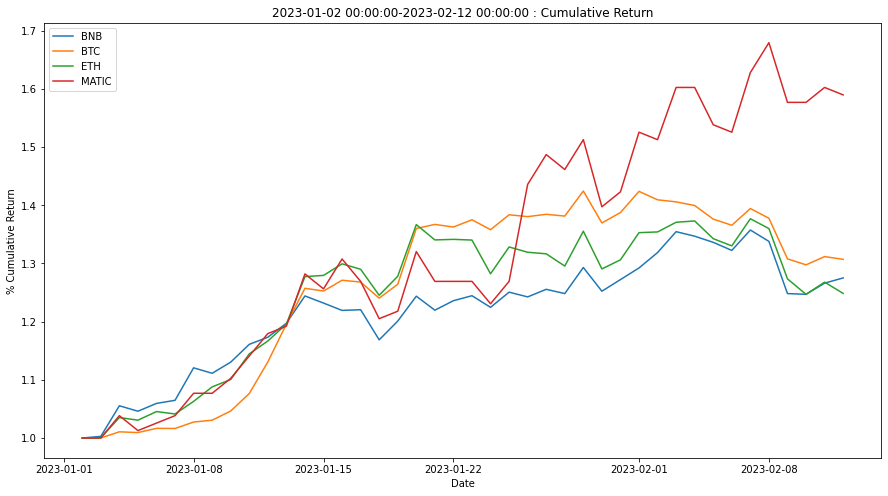

<Figure size 432x288 with 0 Axes>

In [92]:
print("plot chart line to compare return performace entire period")
start_date=fundPerfByPeriod_df.loc[0,'Start_Date']
end_date=fundPerfByPeriod_df.loc[len(fundPerfByPeriod_df)-1,'End_Date']

fig = plt.figure(figsize = (15, 8))
for fund_name,fund_df in dictPriceOfFund.items():
  df=create_pct_acc_df(fund_df,start_date,end_date)  
  #print(df.head())
  plt.plot(df.index,df['cum_return_pct'],label =fund_name)  
plt.legend() 
plt.xlabel("Date")
plt.ylabel("% Cumulative Return")
plt.title(f"{start_date}-{end_date} : Cumulative Return")

if isPy==False:
 plt.show()   


plt.savefig(f'{report_path}\\All Movement.png')

plot chart line to compare return performace on each period


C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['pct_change']=df_temp['price'].pct_change()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cum_return_pct']=(1+df_temp['pct_change']).cumprod()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

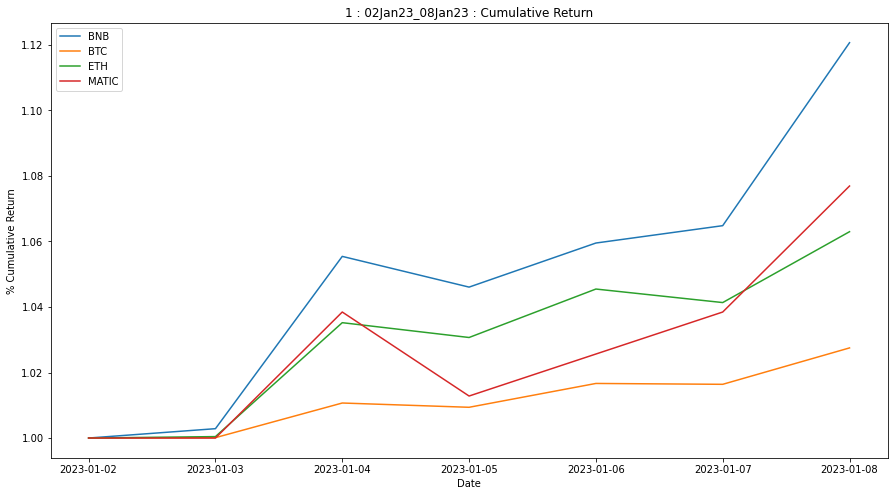

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['pct_change']=df_temp['price'].pct_change()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cum_return_pct']=(1+df_temp['pct_change']).cumprod()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

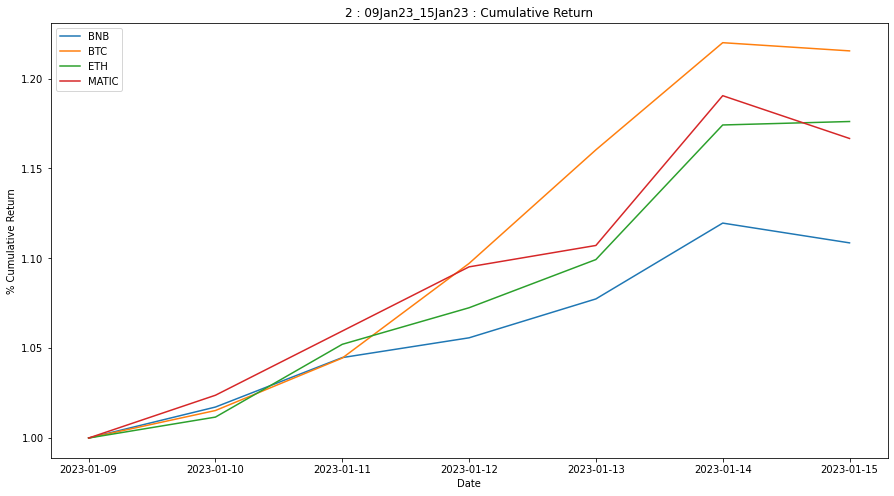

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['pct_change']=df_temp['price'].pct_change()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cum_return_pct']=(1+df_temp['pct_change']).cumprod()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

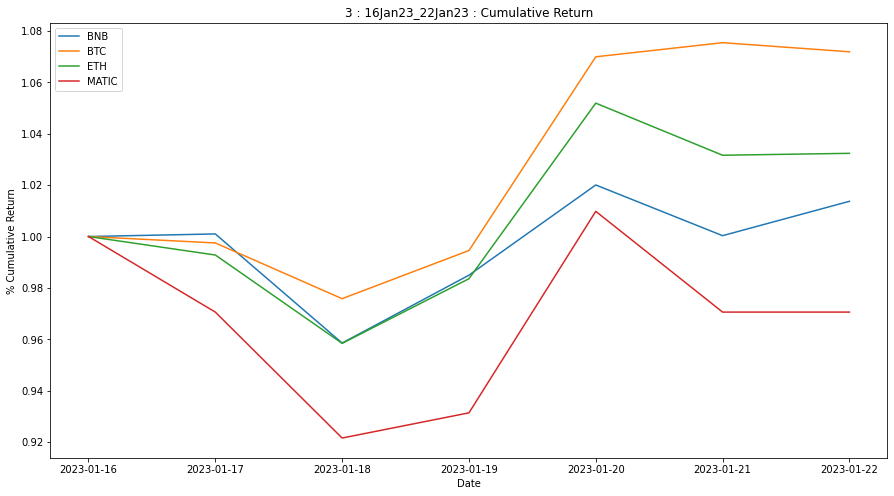

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['pct_change']=df_temp['price'].pct_change()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cum_return_pct']=(1+df_temp['pct_change']).cumprod()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

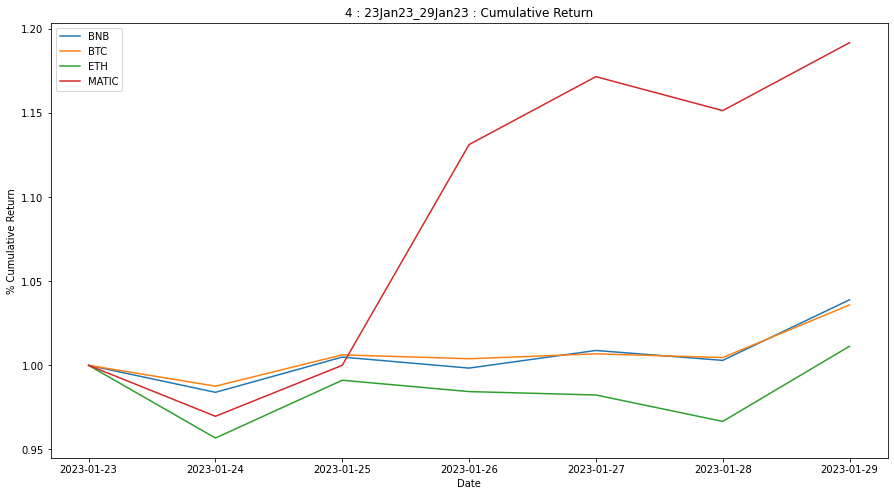

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['pct_change']=df_temp['price'].pct_change()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cum_return_pct']=(1+df_temp['pct_change']).cumprod()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

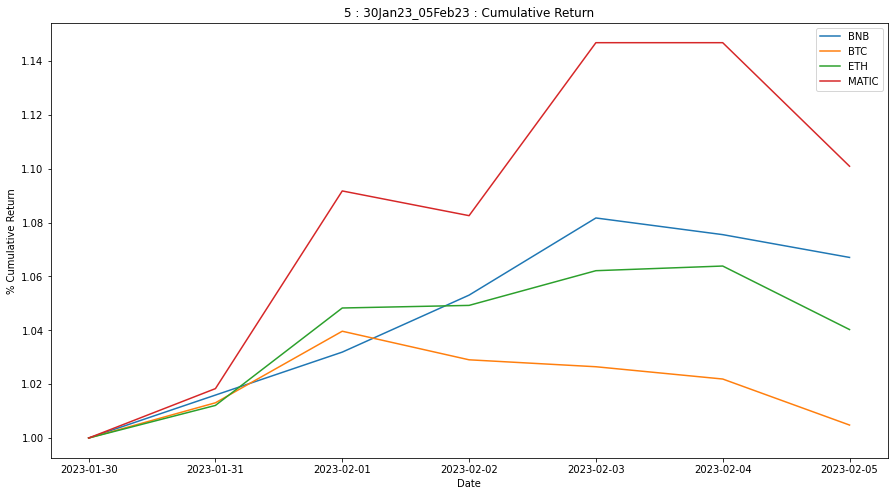

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['pct_change']=df_temp['price'].pct_change()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cum_return_pct']=(1+df_temp['pct_change']).cumprod()
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3295285689.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

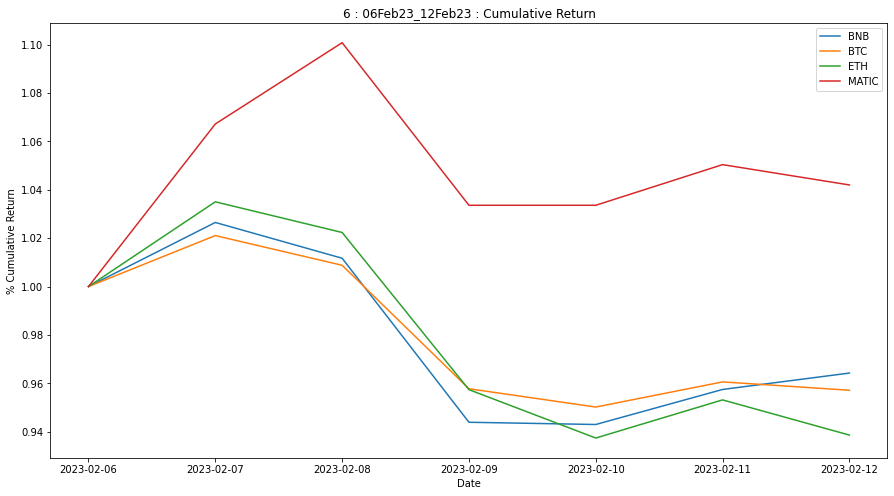

In [93]:
print("plot chart line to compare return performace on each period")
count_pic=0
for index,item in fundPerfByPeriod_df.iterrows():
    
    start_date=item['Start_Date']
    end_date=item['End_Date'] 
    # print(start_date)
    fig = plt.figure(figsize = (15, 8))
    for fund_name,fund_df in dictPriceOfFund.items():
      df=create_pct_acc_df(fund_df,start_date,end_date)  
      #print(df.head())
      plt.plot(df.index,df['cum_return_pct'],label =fund_name)  
    plt.legend() 
    plt.xlabel("Date")
    plt.ylabel("% Cumulative Return")
    
    count_pic=count_pic+1
    plt.title(f"{count_pic} : {item['Period']} : Cumulative Return")
    if isPrintEcahPeriod:
     plt.savefig(f'{report_path}\\{count_pic}-{item["Period"]}.png')
    
    if isPy==False:
     plt.show()   

# Find Percent of Change (ROC) and  Statistic description

In [94]:
def cal_percent_return(item,fundTemp_df):
    
    start_date=item['Start_Date']
    end_date=item['End_Date']
    
    # filter by date to find ROC of price column during the period
    tempDF=fundTemp_df.loc[start_date:end_date,:]
    if tempDF.empty==False:

        start_price=float(tempDF.iloc[0, 0])  # the first record of fund during the given period (timeframe)
        end_price=float(tempDF.iloc[len(tempDF)-1, 0]) # the last record of fund during the given period (timeframe)

        invest_return =(end_price-start_price)/start_price*100
        invest_return=round(invest_return,2)    

        print(f"{start_date.strftime('%d%b%y')} to {end_date.strftime('%d%b%y')}: ROC = ({end_price}-{start_price})/{start_price}x100= {invest_return} %")

        return invest_return
    else:
        return 0

print("Add column by each ROC of symbol")
for name,data in dictPriceOfFund.items():

  print(f"=========================={name} - cal_percent_return==================================================")
  fundPerfByPeriod_df[name]=fundPerfByPeriod_df.apply(cal_percent_return,axis=1,args=(data,))
  print("***********************************************************************************************")

fundPerfByPeriod_df["_AVG_"]=fundPerfByPeriod_df[list_fund_name].mean(axis=1,skipna=True).round(2)

fundPerfByPeriod_df.set_index('Period',inplace=True)   
fundPerfByPeriod_df

Add column by each ROC of symbol
==========================BNB - cal_percent_return==================================================
02Jan23 to 08Jan23: ROC = (274.9-245.3)/245.3x100= 12.07 %
09Jan23 to 15Jan23: ROC = (302.2-272.6)/272.6x100= 10.86 %
16Jan23 to 22Jan23: ROC = (303.2-299.1)/299.1x100= 1.37 %
23Jan23 to 29Jan23: ROC = (317.2-305.3)/305.3x100= 3.9 %
30Jan23 to 05Feb23: ROC = (327.8-307.2)/307.2x100= 6.71 %
06Feb23 to 12Feb23: ROC = (312.8-324.4)/324.4x100= -3.58 %
***********************************************************************************************
==========================BTC - cal_percent_return==================================================
02Jan23 to 08Jan23: ROC = (17126.05-16667.55)/16667.55x100= 2.75 %
09Jan23 to 15Jan23: ROC = (20878.72-17178.38)/17178.38x100= 21.54 %
16Jan23 to 22Jan23: ROC = (22711.92-21188.31)/21188.31x100= 7.19 %
23Jan23 to 29Jan23: ROC = (23743.76-22919.92)/22919.92x100= 3.59 %
30Jan23 to 05Feb23: ROC = (22938.62-22828.57)/2282

,Start_Date,End_Date,BNB,BTC,ETH,MATIC,_AVG_
Period,,,,,,,
02Jan23_08Jan23,2023-01-02,2023-01-08,12.07,2.75,6.30,7.69,7.20
09Jan23_15Jan23,2023-01-09,2023-01-15,10.86,21.54,17.61,16.67,16.67
16Jan23_22Jan23,2023-01-16,2023-01-22,1.37,7.19,3.24,-2.94,2.22
23Jan23_29Jan23,2023-01-23,2023-01-29,3.90,3.59,1.13,19.19,6.95
30Jan23_05Feb23,2023-01-30,2023-02-05,6.71,0.48,4.03,10.09,5.33
06Feb23_12Feb23,2023-02-06,2023-02-12,-3.58,-4.29,-6.14,4.20,-2.45


# Find rank of each fund between peers

In [95]:
def find_rank(fund_temp,list_fundX,FinalRank_ColName):
    fundPerfRank=fund_temp[list_fundX]
    # fundPerfRank.index.set_names('Period',inplace=True)
    fundPerfRank=fundPerfRank.T # transpose to find rank
    #print(fundPerfRank)
    
    for colNameToRank in fundPerfRank.columns:
      fundPerfRank[colNameToRank]=fundPerfRank[colNameToRank].rank(method='max')    
    
    return fundPerfRank
rankCol_name_all='AllRank'
fundRank_df=find_rank(fundPerfByPeriod_df[list_fund_name],list_fund_name,rankCol_name_all)
fundRank_df=fundRank_df.T  # tranpose back to same format as others
fundRank_df


,BNB,BTC,ETH,MATIC
Period,,,,
02Jan23_08Jan23,4.0,1.0,2.0,3.0
09Jan23_15Jan23,1.0,4.0,3.0,2.0
16Jan23_22Jan23,2.0,4.0,3.0,1.0
23Jan23_29Jan23,3.0,2.0,1.0,4.0
30Jan23_05Feb23,3.0,1.0,2.0,4.0
06Feb23_12Feb23,3.0,2.0,1.0,4.0


# Compared  whether outperform its peers or not

In [96]:
fundPerfByPeriod_df

,Start_Date,End_Date,BNB,BTC,ETH,MATIC,_AVG_
Period,,,,,,,
02Jan23_08Jan23,2023-01-02,2023-01-08,12.07,2.75,6.30,7.69,7.20
09Jan23_15Jan23,2023-01-09,2023-01-15,10.86,21.54,17.61,16.67,16.67
16Jan23_22Jan23,2023-01-16,2023-01-22,1.37,7.19,3.24,-2.94,2.22
23Jan23_29Jan23,2023-01-23,2023-01-29,3.90,3.59,1.13,19.19,6.95
30Jan23_05Feb23,2023-01-30,2023-02-05,6.71,0.48,4.03,10.09,5.33
06Feb23_12Feb23,2023-02-06,2023-02-12,-3.58,-4.29,-6.14,4.20,-2.45


In [97]:

def comapre_to_avg(row,fund_name):
    if row[fund_name]>row['_AVG_']:
        return 1
    else:
        return 0
fundRefAvgScore_df= pd.DataFrame(index=fundPerfByPeriod_df.index)
# for index,item in fundPerfByPeriod_df.iterrows():
for fund_name in list_fund_name:
    fundRefAvgScore_df[fund_name]=fundPerfByPeriod_df.apply(comapre_to_avg,axis=1,args=(fund_name,))
fundRefAvgScore_df

,BNB,BTC,ETH,MATIC
Period,,,,
02Jan23_08Jan23,1,0,0,1
09Jan23_15Jan23,0,1,1,0
16Jan23_22Jan23,0,1,1,0
23Jan23_29Jan23,0,0,0,1
30Jan23_05Feb23,1,0,0,1
06Feb23_12Feb23,0,0,0,1


# Summary total return and the number of time to beat the average return

In [98]:
dfSummary=pd.concat([\
                     fundPerfByPeriod_df[list_fund_name].sum().to_frame(name='total_return'),\
                     fundRank_df.sum().to_frame(name='sum_rank_score'),\
                     fundRefAvgScore_df.sum().to_frame(name='sum_outperform_avg')  
                    ],axis=1)
dfSummary.fillna(value=0,inplace=True)
dfSummary


,total_return,sum_rank_score,sum_outperform_avg
BNB,31.33,16.0,2
BTC,31.26,14.0,2
ETH,26.17,12.0,2
MATIC,54.90,18.0,4


# Final Score by sum of rank of all criteria

In [99]:
dfFinalScore=pd.DataFrame(index=dfSummary.index)

for colNameToRank in dfSummary.columns:
  dfFinalScore[f"{colNameToRank}_rank"]=dfSummary[colNameToRank].rank(method='max')  
dfFinalScore=pd.concat([dfFinalScore,dfFinalScore.sum(axis=1).to_frame("TotalScore")],axis=1)
dfFinalScore

,total_return_rank,sum_rank_score_rank,sum_outperform_avg_rank,TotalScore
BNB,3.0,3.0,3.0,9.0
BTC,2.0,2.0,3.0,7.0
ETH,1.0,1.0,3.0,5.0
MATIC,4.0,4.0,4.0,12.0


In [100]:
dfSummary=pd.merge(left=dfSummary,right=dfFinalScore,left_index=True,right_index=True)
dfSummary.sort_values(by='TotalScore',ascending=False,inplace=True)
dfSummary.sort_index(axis=1,ascending=False,inplace=True)
dfSummary

,total_return_rank,total_return,sum_rank_score_rank,sum_rank_score,sum_outperform_avg_rank,sum_outperform_avg,TotalScore
MATIC,4.0,54.90,4.0,18.0,4.0,4,12.0
BNB,3.0,31.33,3.0,16.0,3.0,2,9.0
BTC,2.0,31.26,2.0,14.0,3.0,2,7.0
ETH,1.0,26.17,1.0,12.0,3.0,2,5.0


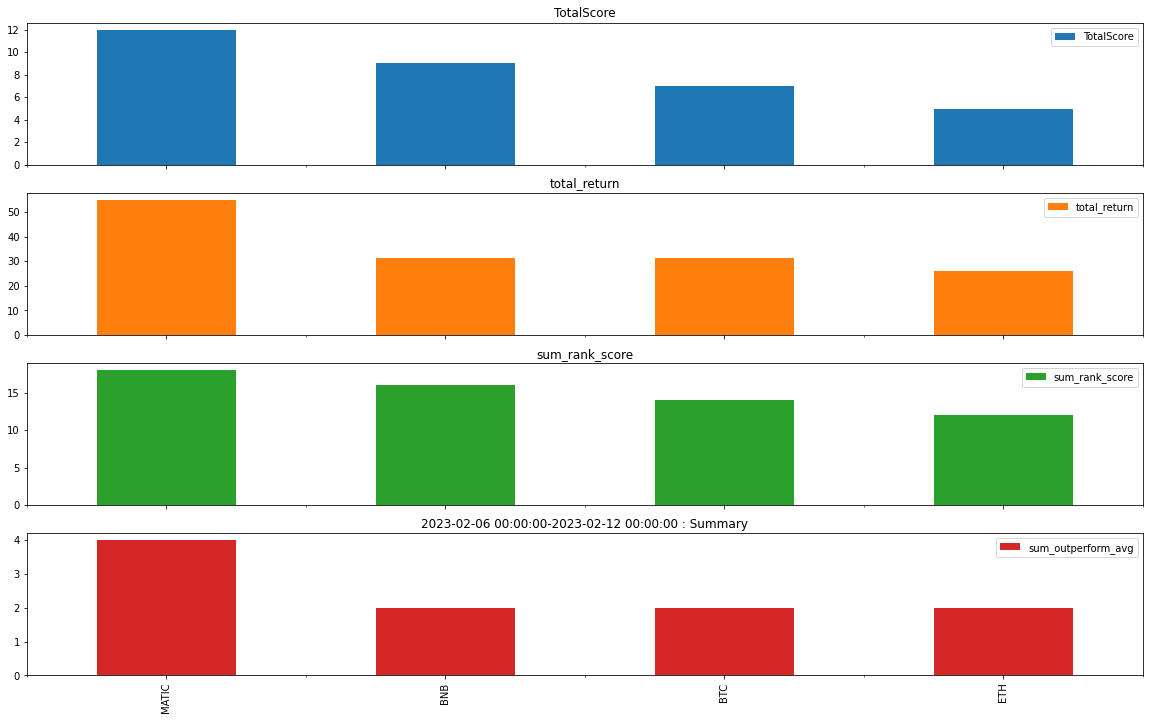

In [101]:
colToPlots=['TotalScore','total_return','sum_rank_score','sum_outperform_avg' ]

dfSummary[colToPlots].plot(kind='bar',layout=(len(colToPlots),1),
                      subplots=True,figsize=(20, 3*len(colToPlots)))
plt.title(f"{start_date}-{end_date} : Summary")
plt.savefig(f'{report_path}\\{from_str}-{to_str}-summary.png')
   
plt.show()


# Plot Bar Perfoamce

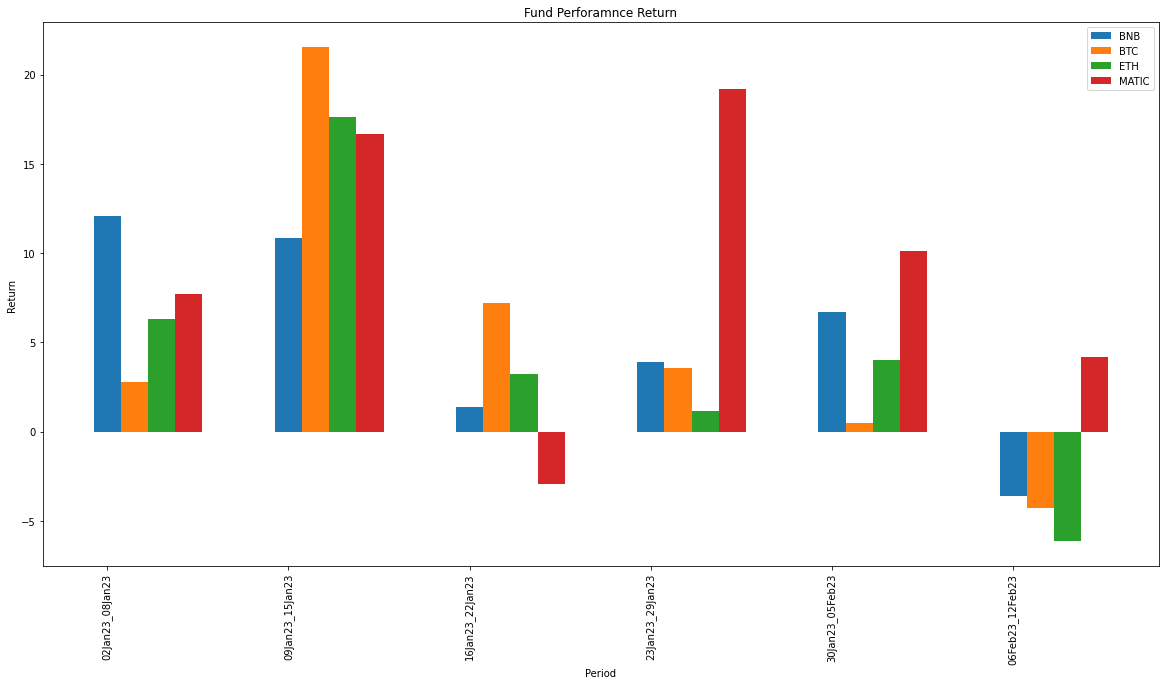

In [102]:
fundReturn_df=fundPerfByPeriod_df[list_fund_name]
fig = plt.figure(figsize = (20, 10))
X_axis = np.arange(len(fundReturn_df)) # length of column to fix axis=y
X_point=0.00
X_width=0.15

for colName  in fundReturn_df.columns:
    
    plt.bar(X_axis+X_point,fundReturn_df[colName],X_width, label =colName)
    X_point+=X_width

# length of column to fix axis=y
plt.xticks(X_axis, fundReturn_df.index,rotation='vertical')
plt.xlabel("Period")
plt.ylabel("Return")
plt.title(f"Fund Perforamnce Return")
plt.legend()

plt.savefig(f'{report_path}\\Return_{from_str}_{to_str}.png')

plt.show()



# Plot correlation

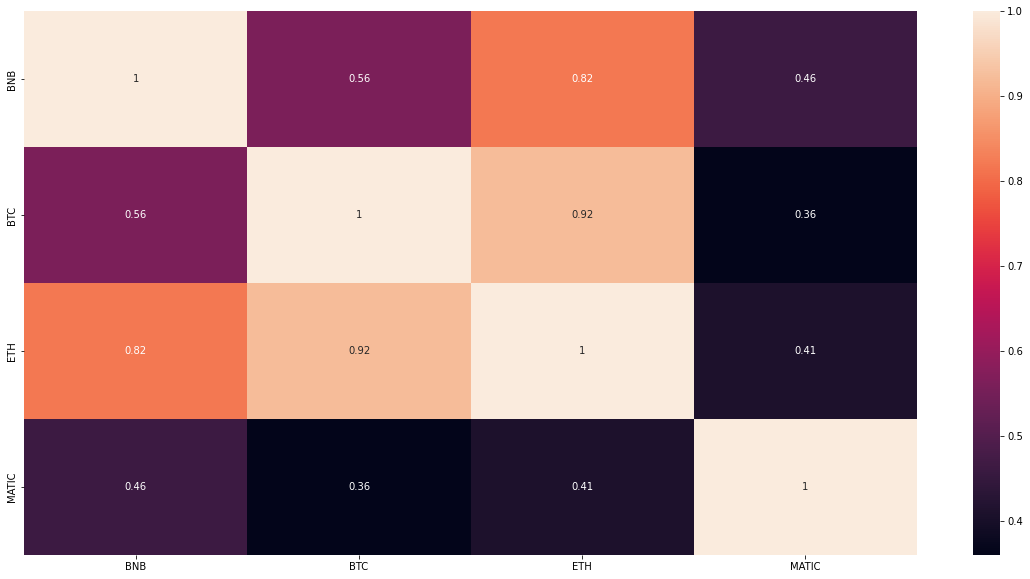

,BNB,BTC,ETH,MATIC
BNB,1.00,0.56,0.82,0.46
BTC,0.56,1.00,0.92,0.36
ETH,0.82,0.92,1.00,0.41
MATIC,0.46,0.36,0.41,1.00


In [103]:
corr_df = fundReturn_df.corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (20, 10))
heatmap = seaborn. heatmap(corr_df, annot = True)  

plt.savefig(f'{report_path}\\Corr_{from_str}_{to_str}.png')
plt. show ()  

corr_df

In [104]:
# add last row to find sum

fundSummaryReturn=fundPerfByPeriod_df.sum().to_frame(f"All Period").T
fundSummaryReturn.insert(0,"Start_Date",from_str,True)
fundSummaryReturn.insert(1,"End_Date",from_str,True)
fundSummaryReturn=  pd.concat([fundPerfByPeriod_df,fundSummaryReturn])
fundSummaryReturn

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\103717733.py:3: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  fundSummaryReturn=fundPerfByPeriod_df.sum().to_frame(f"All Period").T


,Start_Date,End_Date,BNB,BTC,ETH,MATIC,_AVG_
02Jan23_08Jan23,2023-01-02 00:00:00,2023-01-08 00:00:00,12.07,2.75,6.30,7.69,7.20
09Jan23_15Jan23,2023-01-09 00:00:00,2023-01-15 00:00:00,10.86,21.54,17.61,16.67,16.67
16Jan23_22Jan23,2023-01-16 00:00:00,2023-01-22 00:00:00,1.37,7.19,3.24,-2.94,2.22
23Jan23_29Jan23,2023-01-23 00:00:00,2023-01-29 00:00:00,3.90,3.59,1.13,19.19,6.95
30Jan23_05Feb23,2023-01-30 00:00:00,2023-02-05 00:00:00,6.71,0.48,4.03,10.09,5.33
06Feb23_12Feb23,2023-02-06 00:00:00,2023-02-12 00:00:00,-3.58,-4.29,-6.14,4.20,-2.45
All Period,2023-01-02,2023-01-02,31.33,31.26,26.17,54.90,35.92


In [106]:
report_file = os.path .join(report_path, "Report.xlsx")
writer=pd.ExcelWriter(report_file,engine='xlsxwriter') 

fundPerfByPeriod_df.to_excel(writer, sheet_name="Return")
fundSummaryReturn.to_excel(writer, sheet_name="SumReturn")
fundRefAvgScore_df.to_excel(writer, sheet_name="OutperformAVG")
fundRank_df.to_excel(writer, sheet_name="RANK")
dfSummary.to_excel(writer, sheet_name="Summary")

corr_df.to_excel(writer, sheet_name="Des",index=True)
writer.save()

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_11944\3919334011.py:11: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer.save()
